# Анализ поведения пользователей в мобильном приложении

# Описание проекта

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.

# Исходные данные

Данные содержатся в файле logs_exp.csv.  
Каждая запись в логе — это действие пользователя, или событие.  
`EventName` — название события;  
`DeviceIDHash` — уникальный идентификатор пользователя;  
`EventTimestamp` — время события;  
`ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

In [ ]:
import pandas as pd
import numpy as np
import math as mth
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
from scipy import stats as st

## Откройте файл с данными и изучите общую информацию

In [2]:
try:
    logs_exp = pd.read_csv('C:\\Users\\Arwin77\\Documents\\Python Scripts\\logs_exp.csv', sep='\t')
except FileNotFoundError:
    logs_exp = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [3]:
logs_exp.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
logs_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


**Вывод по разделу**  

Представленные данные имеют 244126 строки, 4 колонки.  
Пропущенные значения отсутствуют.
Имеются полные дубликаты.
Необходимо:  
- перевести тип колонки `EventTimestamp` из `int64` в `datetime`.  
- убрать `camel case`;  
- убрать дубликаты.

## Подготовьте данные

### Замените названия столбцов на удобные для вас

In [5]:
logs_exp.columns = logs_exp.columns.str.replace(" ", "_").str.lower()

### Проверьте пропуски и типы данных. Откорректируйте, если нужно

In [6]:
logs_exp.duplicated().sum()

413

In [7]:
logs_exp = logs_exp.drop_duplicates()
logs_exp.head()

,eventname,deviceidhash,eventtimestamp,expid
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


### Добавьте столбец даты и времени, а также отдельный столбец дат

In [8]:
logs_exp['datetime'] = pd.to_datetime(logs_exp['eventtimestamp'], unit='s')
logs_exp['date'] = logs_exp['datetime'].dt.strftime('%Y-%m-%d')#.astype('datetime64')
logs_exp.head()

,eventname,deviceidhash,eventtimestamp,expid,datetime,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [9]:
logs_exp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   eventname       243713 non-null  object        
 1   deviceidhash    243713 non-null  int64         
 2   eventtimestamp  243713 non-null  int64         
 3   expid           243713 non-null  int64         
 4   datetime        243713 non-null  datetime64[ns]
 5   date            243713 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 13.0+ MB


In [10]:
# проверим отсутствие пересечения пользователей в группах
pd.crosstab(logs_exp['deviceidhash'], logs_exp['expid']).sort_values(by=[246, 247,248], ascending=False).head()

expid,246,247,248
deviceidhash,,,
197027893265565660,1998,0,0
3337471580007169353,1186,0,0
7738058666231999878,888,0,0
1055544042902443290,854,0,0
8118046800480174342,755,0,0


In [12]:
logs_exp.groupby(['deviceidhash']).agg({'expid': 'nunique'}).sort_values(by='expid', ascending=False).head()

,expid
deviceidhash,
6888746892508752,1
6207768971558512760,1
6217807653094995999,1
6217295124800833842,1
6216080220799726690,1


**Вывод по разделу**  

Данные к анализу подготовленны:  
- типы данных корректны;  
- текстовые данные приведены к единому регистру;
- пропусков не обаружено;
- удалены явные дубликаты;
- добавлены столбцы `datetime`, `date`;
- пересечения пользователей в группах отсутствует.

## Изучите и проверьте данные

### Сколько всего событий в логе?

In [13]:
logs_exp['eventname'].count()

243713

In [14]:
df = logs_exp.groupby('eventname').agg({'deviceidhash': 'count'})\
        .reset_index()\
        .rename(columns={'deviceidhash': 'countevent'})\
        .sort_values(by='countevent', ascending=False)
df['fraction'] = round(df['countevent'] / logs_exp['eventname'].count(), 2)
df

,eventname,countevent,fraction
1,MainScreenAppear,119101,0.49
2,OffersScreenAppear,46808,0.19
0,CartScreenAppear,42668,0.18
3,PaymentScreenSuccessful,34118,0.14
4,Tutorial,1018,0.00


Всего событий в логе 243713.  
Событие `MainScreenAppear` имеет наибольшую долю от всех событий (49%), событие `Tutorial` имеет наименьшую долю (менее 1%).

### Сколько всего пользователей в логе?

In [15]:
users_total = logs_exp['deviceidhash'].nunique()
users_total

7551

Всего уникальных пользователей в логе 7551.

### Сколько в среднем событий приходится на пользователя?

In [16]:
round(logs_exp['eventname'].count() / logs_exp['deviceidhash'].nunique())

32

В среднем на каждого пользователя приходится 32 события. Но надо посмотреть выбросы.

In [17]:
df = logs_exp.groupby('deviceidhash').agg({'eventname': 'count'})
#df

In [ ]:
fig = px.box(df, y="eventname")
fig.update_layout(
    title="Boxplot числа событий на одного пользователя",
    yaxis_title="Количество событий, шт",
    font=dict(family="Times New Roman, monospace",
                size=18,
                color="RebeccaPurple")
)

fig.show()

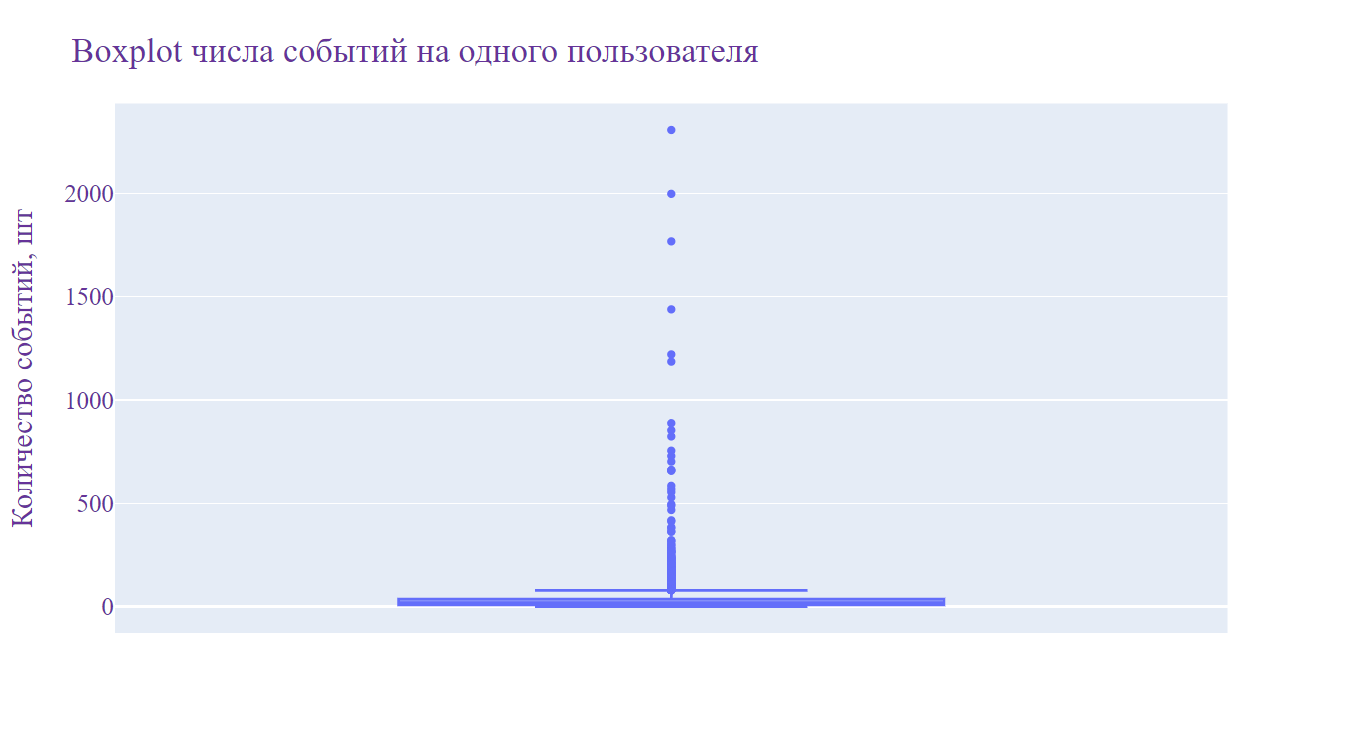

Видим выбросы, более 2000. Соответственно в данном случае лучше использовать медиану.

In [19]:
df.median()

eventname    20.0
dtype: float64

В среднем на каждого пользователя приходится 20 событий.

### Данными за какой период вы располагаете? 
Найдите максимальную и минимальную дату.  
Постройте гистограмму по дате и времени. Можно ли быть уверенным, что у вас одинаково полные данные за весь период?  
Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые.  
Данными за какой период времени вы располагаете на самом деле?

In [20]:
logs_exp['date'].max()

'2019-08-07'

In [21]:
logs_exp['date'].min()

'2019-07-25'

In [ ]:
fig = px.histogram(logs_exp['datetime'], marginal="box")
fig.update_layout(
    title="Распределение событий по времени",
    xaxis_title="Время события",
    yaxis_title="Количество событий",
    legend_title="Легенда",
    font=dict(family="Times New Roman, monospace",
                size=18,
                color="RebeccaPurple")
)
fig.show()

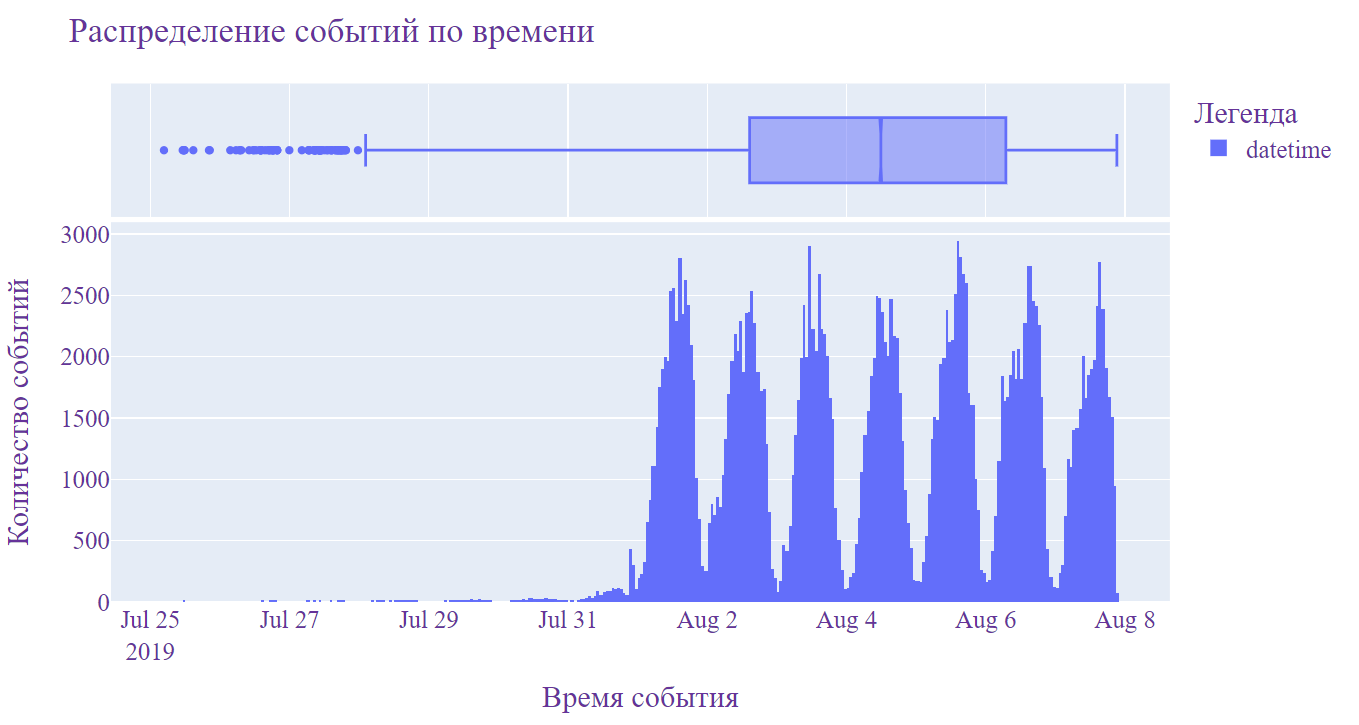

Данные имеют период с 2019-07-25 по 2019-08-07. По гистограмме событий видно, что до 1 августа количество событий минимально. Таким образом релевантные данные имеются в период с 2019-08-01 по 2019-08-07. Для дальнейшего анализа отбросим данные старше 2019-08-01.

In [23]:
logs_exp_new = logs_exp[logs_exp['date'] >= '2019-08-01']
logs_exp_new.head()

,eventname,deviceidhash,eventtimestamp,expid,datetime,date
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01


### Много ли событий и пользователей вы потеряли, отбросив старые данные?

In [24]:
round(100 * (logs_exp.shape[0] - logs_exp_new.shape[0]) / logs_exp.shape[0], 2)

1.16

In [26]:
round(100 * (logs_exp['deviceidhash'].nunique() - logs_exp_new['deviceidhash'].nunique()) / logs_exp['deviceidhash']\
          .nunique(), 2)

0.23

Отбросив старые данные мы потеряли незначительное количество событий (1.16%) и пользователей (0.23%).

### Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

In [29]:
logs_exp_new.groupby('expid').agg({'deviceidhash': 'nunique', 'expid': 'count'})

,deviceidhash,expid
expid,,
246,2484,79302
247,2513,77022
248,2537,84563


**Вывод по разделу**  
- Всего событий в логе 243713.  
- Событие `MainScreenAppear` имеет наибольшую долю от всех событий (49%), событие `Tutorial` имеет наименьшую долю (менее 1%).  
- Всего уникальных пользователей в логе 7551.  
- В среднем на каждого пользователя приходится 20 событий.
- В процессе предобработки данных были исключены для дальнейшего анализа данные старше 2019-08-01. Отбросив старые данные мы потеряли незначительное количество событий (1.16%) и пользователей (0.23%).  
- Пользователи распределены равномерно по всем группам.

## Изучите воронку событий

### Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.

In [30]:
logs_exp_new.groupby('eventname', as_index=False).agg({'deviceidhash': 'count'})\
        .rename(columns={'deviceidhash': 'total'})\
        .sort_values(by='total', ascending=False)

,eventname,total
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
0,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


### Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.

In [31]:
users = logs_exp_new.groupby('eventname').agg({'deviceidhash': 'nunique', 'eventname': 'count'})\
        .rename(columns={'deviceidhash': 'users', 'eventname': 'event_total'})\
        .sort_values(by='users', ascending=False)\
        .reset_index()
users['fraction'] = round(100 * users['users'] / users_total, 2)
users

,eventname,users,event_total,fraction
0,MainScreenAppear,7419,117328,98.25
1,OffersScreenAppear,4593,46333,60.83
2,CartScreenAppear,3734,42303,49.45
3,PaymentScreenSuccessful,3539,33918,46.87
4,Tutorial,840,1005,11.12


### Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.

In [ ]:
fig = px.histogram(users, x="eventname", y="fraction") #, text_auto=True)
fig.update_layout(
    title="Столбчатая диаграмма событий",
    xaxis_title="Событие",
    yaxis_title="Доля пользователей, %",
    font=dict(family="Times New Roman, monospace",
                size=18,
                color="RebeccaPurple")
)
fig.show()

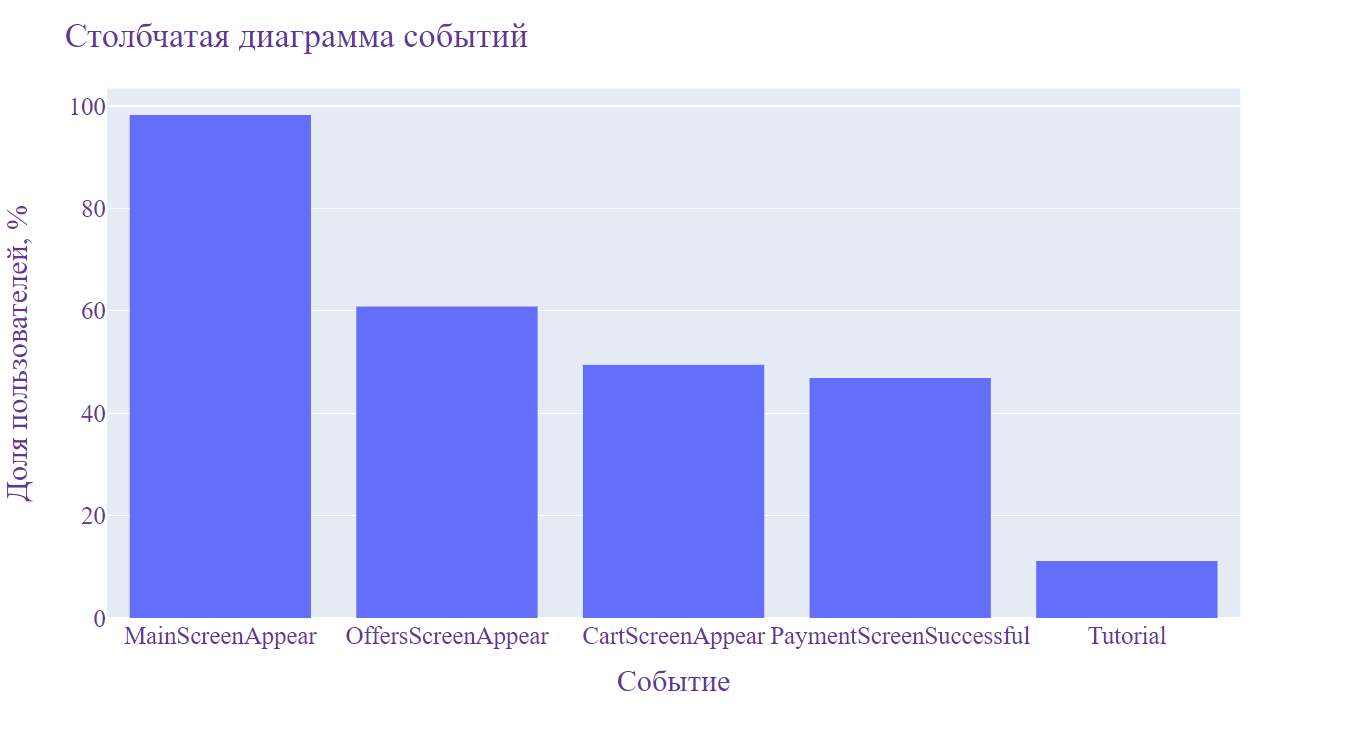

События происходят в следующем порядке:  
- Открытие главного окна  
- Открытие окна предложения
- Открытие окна корзины  
- Открытие окна оплаты  
- Открытие окна руководства  
Событие `Tutorial` особой пользы не имеет.

### По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). 
То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

In [ ]:
fig = go.Figure(go.Funnel(x=users['users'], y=users['eventname'], textinfo = "value+percent initial+percent previous"))
fig.update_layout(
    title="Воронка событий",
    font=dict(family="Times New Roman, monospace",
                size=18,
                color="RebeccaPurple")
)
fig.show();

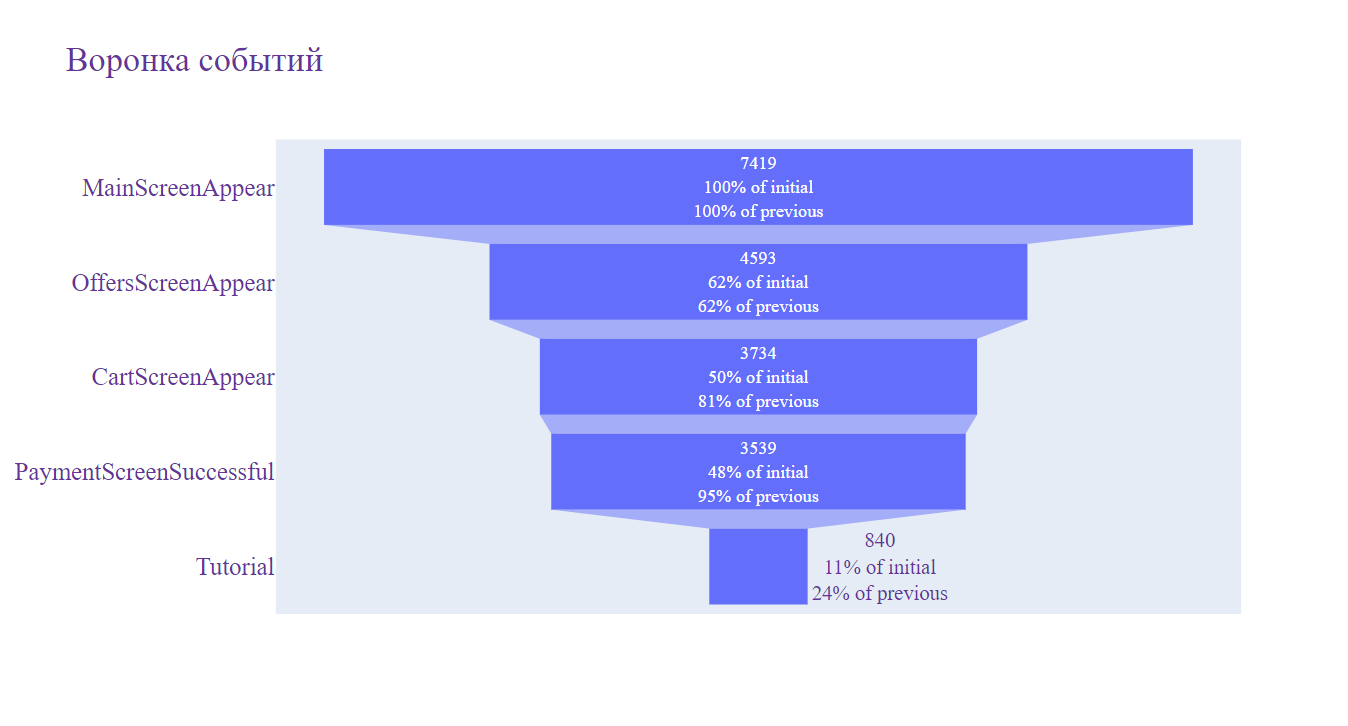

- 7419 пользователя открывали главную страницу приложения(MainScreenAppear). Надо заметить, что уникальных пользователей у нас 7551, соответственно не все пользователи начинали с главной страницы.   
- 4593 пользователя открывали страницу с каталогом товаров(OffersScreenAppear) это 62% от пользователей перешедших с предыдушего шага. 38% пользователей не перешли на следующий шаг. Необходимо выяснить причину, возможно приложение не на всех устройствах работает корректно.  
- 3734 пользователя открывали корзину(CartScreenAppear) это 50% пользователей от первого шага и 81% пользователей от предыдушего шага.  
- 3539 пользователей открыли страницу с успешной оплатой(PaymentScreenSuccessful) это 48% пользователей от первого шага и 95% от предыдущего шага.  
- 840 пользователей открывали руководство пользователя(Tutorial) это 11% пользователей от первого шага и 24% пользователей от предыдущего шага.


### На каком шаге теряете больше всего пользователей?

In [34]:
users['diff'] = users['users'].shift(1) - users['users']

In [35]:
users[['eventname', 'users', 'diff']]

,eventname,users,diff
0,MainScreenAppear,7419,NaN
1,OffersScreenAppear,4593,2826.0
2,CartScreenAppear,3734,859.0
3,PaymentScreenSuccessful,3539,195.0
4,Tutorial,840,2699.0


Больше всего пользователей (2826) теряется после первого шага, открытия главного окна (38%).

### Какая доля пользователей доходит от первого события до оплаты?

In [36]:
users['fraction_step'] = round(100 * users['users'] / users.loc[0, 'users'])
users

,eventname,users,event_total,fraction,diff,fraction_step
0,MainScreenAppear,7419,117328,98.25,NaN,100.0
1,OffersScreenAppear,4593,46333,60.83,2826.0,62.0
2,CartScreenAppear,3734,42303,49.45,859.0,50.0
3,PaymentScreenSuccessful,3539,33918,46.87,195.0,48.0
4,Tutorial,840,1005,11.12,2699.0,11.0


От открытия главного окна до окна оплаты доходит 48% пользователей

**Вывод по разделу**  

Воронка продаж имеет следующий вид:

- `MainScreenAppear` - Открытие главного окна - Вход на сайт  
- `OffersScreenAppear` - Открытие окна предложений - Поиск товара по каталогу  
- `CartScreenAppear` - Открытие окна корзины - Добавление товара в корзину  
- `PaymentScreenSuccessful` - Открытие окна оплаты - Оплата  
- `Tutorial` - Открытие окна руководства - Изучение инструкции  

На второй этап воронки переходит 62% пользователей, а 38% теряются. Здесь необходим дополнительный анализ почему так;

Событие `Tutorial` не несет полезной нагрузки, поэтому его можно не принимать во внимание;

От открытия главного окна до окна оплаты доходит 48% пользователей.

## Изучите результаты эксперимента

### Сколько пользователей в каждой экспериментальной группе?

In [37]:
users_in_group = logs_exp_new.groupby('expid').agg({'deviceidhash': 'nunique'}).T#.reset_index()
users_in_group['246+247'] = users_in_group[246] + users_in_group[247]
users_in_group

expid,246,247,248,246+247
deviceidhash,2484,2513,2537,4997


### Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.

Подготовим данные для дальнейших статистических проверок.

In [38]:
event_group_test = logs_exp_new[logs_exp_new['eventname']!='Tutorial'].pivot_table(
    index='eventname', 
    columns='expid', 
    values='deviceidhash',
    aggfunc='nunique').sort_values(by=246, ascending=False)

In [39]:
event_group_test = event_group_test.reset_index()
event_group_test

expid,eventname,246,247,248
0,MainScreenAppear,2450,2476,2493
1,OffersScreenAppear,1542,1520,1531
2,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181


In [40]:
event_group_test['246+247'] = event_group_test[246] + event_group_test[247]
event_group_test['all'] = event_group_test['246+247'] + event_group_test[248]

event_group_test['frac_246'] = round(100 * event_group_test[246] / users_in_group[246][0], 1)
event_group_test['frac_247'] = round(100 * event_group_test[247] / users_in_group[247][0], 1)
event_group_test['frac_248'] = round(100 * event_group_test[248] / users_in_group[248][0], 1)
event_group_test['frac_246+247'] = round(100 * (event_group_test[246] + event_group_test[247]) /\
                                    (users_in_group[246][0] + users_in_group[246][0]), 1)

In [41]:
event_group_test

expid,eventname,246,247,248,246+247,all,frac_246,frac_247,frac_248,frac_246+247
0,MainScreenAppear,2450,2476,2493,4926,7419,98.6,98.5,98.3,99.2
1,OffersScreenAppear,1542,1520,1531,3062,4593,62.1,60.5,60.3,61.6
2,CartScreenAppear,1266,1238,1230,2504,3734,51.0,49.3,48.5,50.4
3,PaymentScreenSuccessful,1200,1158,1181,2358,3539,48.3,46.1,46.6,47.5


Определим функцию `z_test` в которую будем передавать сравниваемые группы и уровень статистической значимости.  
На выходе функции получаем р-значение и результат гипотезы по всем событиям.  

Н_0: Доли в группах одинаковые.  
Н_1: Доли в группах разные.

In [42]:
def z_test(group_1, group_2, alpha):
    for i in event_group_test.index:
        # пропорция успехов в первой группе:
        p1 = event_group_test[group_1][i] / users_in_group[group_1][0]
        # пропорция успехов во второй группе:
        p2 = event_group_test[group_2][i] / users_in_group[group_2][0]
        # пропорция успехов в комбинированном датасете:
        p_combined = ((event_group_test[group_1][i] + event_group_test[group_2][i]) / 
                      (users_in_group[group_1][0] + users_in_group[group_2][0]))
        # разница пропорций в датасетах
        difference = p1 - p2
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * 
                                        (1/users_in_group[group_1][0] + 1/users_in_group[group_2][0]))
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1) 
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('{} p-значение: {}'.format(event_group_test['eventname'][i], p_value))
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print('')

In [43]:
z_test(246, 247, 0.05)

MainScreenAppear p-значение: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



### Выберите самое популярное событие. 

In [44]:
logs_exp_new['eventname'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: eventname, dtype: int64

Самое популярное событие - `MainScreenAppear`.

- Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. 

In [45]:
event_group_test[['eventname', 246, 247, 248]]

expid,eventname,246,247,248
0,MainScreenAppear,2450,2476,2493
1,OffersScreenAppear,1542,1520,1531
2,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181


- Посчитайте долю пользователей, совершивших это событие. 

In [46]:
event_group_test[['eventname', 'frac_246', 'frac_247', 'frac_248']]

expid,eventname,frac_246,frac_247,frac_248
0,MainScreenAppear,98.6,98.5,98.3
1,OffersScreenAppear,62.1,60.5,60.3
2,CartScreenAppear,51.0,49.3,48.5
3,PaymentScreenSuccessful,48.3,46.1,46.6


Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?

In [47]:
z_test(246, 247, 0.05)

MainScreenAppear p-значение: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод**  
По всем событиям разница не оказалось значимой обе группы можно считать контрольными.

### Аналогично поступите с группой с изменённым шрифтом.
Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

In [48]:
z_test(246, 248, 0.05)

MainScreenAppear p-значение: 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [49]:
z_test(247, 248, 0.05)

MainScreenAppear p-значение: 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [50]:
z_test('246+247', 248, 0.05)

MainScreenAppear p-значение: 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод**  
Сравнение результатов с каждой из контрольных групп и с объединенной контрольной группой не показало значимой разницы.

### Какой уровень значимости вы выбрали при проверке статистических гипотез выше? 
Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

Всего было сделано 16 проверок: 246/247, 246/248, 247/248, 246+247/248.  
Применял уровень значимости 0.05. Попробовал 0.01 - выводы не поменялись.

In [51]:
z_test(246, 247, 0.01)

MainScreenAppear p-значение: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [52]:
z_test(246, 248, 0.01)

MainScreenAppear p-значение: 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [53]:
z_test(247, 248, 0.01)

MainScreenAppear p-значение: 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [54]:
z_test('246+247', 248, 0.01)

MainScreenAppear p-значение: 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



## Общий вывод

Данные имеют период с 2019-07-25 по 2019-08-07. По гистограмме событий видно, что до 1 августа количество событий минимально. Таким образом релевантные данные имеются в период с 2019-08-01 по 2019-08-07. Для дальнейшего анализа отбросил данные старше 2019-08-01.

Воронка продаж имеет следующий вид:

- `MainScreenAppear` - Открытие главного окна - Вход на сайт  
- `OffersScreenAppear` - Открытие окна предложений - Поиск товара по каталогу  
- `CartScreenAppear` - Открытие окна корзины - Добавление товара в корзину  
- `PaymentScreenSuccessful` - Открытие окна оплаты - Оплата  
- `Tutorial` - Открытие окна руководства - Изучение инструкции  

На второй этап воронки переходит 62% пользователей, а 38% теряются. Здесь необходим дополнительный анализ почему так;

Событие `Tutorial` не несет полезной нагрузки, поэтому его можно не принимать во внимание;

От открытия главного окна до окна оплаты доходит 48% пользователей.

Всего было сделано 16 проверок: 246/247, 246/248, 247/248, 246+247/248.
В результате всех A/A/B эксперементов значимой разницы между группами не выявлено. Поэтому можно утверждать, что менеджерам пугаться нечего, на поведение пользователей изменение шрифта значимого эффекта не оказало, дизайнеры все сделали хорошо. 